<a href="https://colab.research.google.com/github/MGentieu/Data_analytics_aircraft_messages/blob/main/GENTIEU_Martin_TP2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GENTIEU Martin : TP2 de data analytics


## Préparation des données utiles pour le TP2 :

###On se place dans un premier temps dans le répertoire parent

In [30]:
import os
import sys
from pathlib import Path

# Detect working directory
cwd = Path.cwd().resolve()

# If in Colab (/content), search for repo folder automatically
if cwd.name == "content":
    # Look for the cloned project automatically
    candidates = [d for d in cwd.iterdir() if d.is_dir() and "aircraft" in d.name.lower()]

    if not candidates:
        raise FileNotFoundError(
            f"Aucun dossier contenant 'aircraft' trouvé dans /content.\n"
            f"Dossiers présents : {os.listdir(cwd)}"
        )

    PROJECT_ROOT = candidates[0]
else:
    PROJECT_ROOT = cwd

print(f"Detected project root: {PROJECT_ROOT}")

# Validate directory
if not PROJECT_ROOT.exists():
    raise FileNotFoundError(f"Missing directory at {PROJECT_ROOT}")

# Add to Python path
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

print("Setup complete.")


Detected project root: /content/Data_analytics_aircraft_messages
Setup complete.


On importe ensuite les bibliothèques nécessaires à l'analyse :

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import folium
import shapely
import socket
import glob
import csv
from datetime import datetime

On exécute ensuite le script python test.py pour récupérer les messages (environ 700 000).
Si un fichier CSV commençant par **"data_TP2_"** existe, alors on n'exécute pas le code de récupération des messages.

In [32]:
HOST = "sbs.glidernet.org"
PORT = 30003

cols = [
    "MessageType", "TransmissionType", "SessionID", "AircraftID", "HexIdent", "FlightID",
    "DateGenerated", "TimeGenerated", "DateLogged", "TimeLogged", "Callsign", "Altitude",
    "GroundSpeed", "Track", "Latitude", "Longitude", "VerticalRate", "Squawk", "Alert",
    "Emergency", "SPI", "IsOnGround"
]

# Cherche un fichier existant data_TP2_*.csv
existing_files = glob.glob(f"{PROJECT_ROOT}/data_TP2_*.csv")

if existing_files:
    # Si plusieurs → on prend le plus récent
    output_file = max(existing_files, key=os.path.getmtime)
    print(f"Fichier existant trouvé : {output_file}")
else:
    # Sinon on en crée un nouveau
    date = datetime.now().strftime('%Y%m%d_%H%M%S')
    output_file = f"{PROJECT_ROOT}/data_TP2_{date}.csv"
    print(f"Aucun fichier existant. Nouveau fichier : {output_file}")


    print(f"Connexion à {HOST}:{PORT} ...")

    with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as s:
        s.connect((HOST, PORT))
        print("Connecté ! Réception des messages ADS-B...\n")

        # Teste si le fichier existe déjà (on ne réécrit pas le header)
        file_exists = os.path.isfile(output_file) and os.path.getsize(output_file) > 0

        with open(output_file, "a", newline="", encoding="utf-8") as f:
            writer = csv.writer(f, delimiter=",")

            # Écrit le header seulement si le fichier est nouveau/vide
            if not file_exists:
                writer.writerow(cols)

            try:
                for i in range(120000):
                    data = s.recv(1024).decode(errors="ignore")

                    for line in data.strip().split("\n"):
                        if line.startswith("MSG"):
                            fields = line.split(",")

                            # Complète si trop court
                            if len(fields) < len(cols):
                                fields += [""] * (len(cols) - len(fields))

                            writer.writerow(fields)

                    if i % 5000 == 0:
                        print(f"{i} itérations traitées")

            except KeyboardInterrupt:
                print("\nArrêt manuel par l’utilisateur.")
            except Exception as e:
                print("Erreur :", e)

    print(f"\nDonnées enregistrées dans : {output_file}")


Fichier existant trouvé : /content/Data_analytics_aircraft_messages/data_TP2_20251120_081609.csv


###Récupération des données utiles pour un avion (en utilisant l'identifiant ICAO)

In [33]:
df = pd.read_csv(output_file)
#df = df[0].str.split(",", expand=True)

Analyse initiale du dataset :

In [34]:
df.head()

,MessageType,TransmissionType,SessionID,AircraftID,HexIdent,FlightID,DateGenerated,TimeGenerated,DateLogged,TimeLogged,...,GroundSpeed,Track,Latitude,Longitude,VerticalRate,Squawk,Alert,Emergency,SPI,IsOnGround
0,MSG,3.0,NaN,NaN,4B1E44,NaN,2025/11/20,08:16:09.371,2025/11/20,08:16:09.371,...,99.0,218.0,47.16300,7.35615,NaN,NaN,0.0,0.0,0.0,0.0
1,MSG,3.0,NaN,NaN,3D2A42,NaN,2025/11/20,08:16:09.374,2025/11/20,08:16:09.374,...,256.0,115.0,48.57190,12.19607,NaN,NaN,0.0,0.0,0.0,0.0
2,MSG,3.0,NaN,NaN,48415E,NaN,2025/11/20,08:16:09.375,2025/11/20,08:16:09.375,...,237.0,328.0,52.13917,-1.40272,NaN,NaN,0.0,0.0,0.0,0.0
3,MSG,3.0,NaN,NaN,4D2411,NaN,2025/11/20,08:16:09.377,2025/11/20,08:16:09.377,...,376.0,6.0,49.98868,9.47375,NaN,NaN,0.0,0.0,0.0,0.0
4,MSG,3.0,NaN,NaN,3C70C7,NaN,2025/11/20,08:16:09.381,2025/11/20,08:16:09.381,...,427.0,121.0,49.75452,9.17745,NaN,NaN,0.0,0.0,0.0,0.0


In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18687 entries, 0 to 18686
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   MessageType       18687 non-null  object 
 1   TransmissionType  18637 non-null  float64
 2   SessionID         0 non-null      float64
 3   AircraftID        0 non-null      float64
 4   HexIdent          18548 non-null  object 
 5   FlightID          0 non-null      float64
 6   DateGenerated     18416 non-null  object 
 7   TimeGenerated     18242 non-null  object 
 8   DateLogged        17777 non-null  object 
 9   TimeLogged        17564 non-null  object 
 10  Callsign          17358 non-null  object 
 11  Altitude          17133 non-null  float64
 12  GroundSpeed       16936 non-null  float64
 13  Track             16689 non-null  float64
 14  Latitude          16533 non-null  float64
 15  Longitude         16377 non-null  object 
 16  VerticalRate      0 non-null      float6

In [36]:
df.describe()

,TransmissionType,SessionID,AircraftID,FlightID,Altitude,GroundSpeed,Track,Latitude,VerticalRate,Squawk,Alert,Emergency,SPI,IsOnGround
count,18637.0,0.0,0.0,0.0,17133.000000,16936.000000,16689.000000,16533.000000,0.0,0.0,16183.0,16144.0,16098.0,16031.0
mean,3.0,NaN,NaN,NaN,12560.770385,265.184046,166.959315,47.008710,NaN,NaN,0.0,0.0,0.0,0.0
std,0.0,NaN,NaN,NaN,10127.106443,120.505166,102.752300,13.728434,NaN,NaN,0.0,0.0,0.0,0.0
min,3.0,NaN,NaN,NaN,0.000000,0.000000,0.000000,-44.674730,NaN,NaN,0.0,0.0,0.0,0.0
25%,3.0,NaN,NaN,NaN,4452.000000,195.000000,84.000000,45.111880,NaN,NaN,0.0,0.0,0.0,0.0
50%,3.0,NaN,NaN,NaN,10488.000000,283.000000,156.000000,50.090320,NaN,NaN,0.0,0.0,0.0,0.0
75%,3.0,NaN,NaN,NaN,16063.000000,340.000000,251.000000,51.811920,NaN,NaN,0.0,0.0,0.0,0.0
max,3.0,NaN,NaN,NaN,39764.000000,522.000000,360.000000,69.839580,NaN,NaN,0.0,0.0,0.0,0.0


###1.2. Extraction des colonnes utiles

In [37]:
df_parsed = pd.DataFrame({
    'icao': df["HexIdent"],
    'registration': df["Callsign"],
    'altitude': pd.to_numeric(df["Altitude"], errors='coerce'),
    'velocity': pd.to_numeric(df["GroundSpeed"], errors='coerce'),
    'heading': pd.to_numeric(df["Track"], errors='coerce'),
    'lat': pd.to_numeric(df["Latitude"], errors='coerce'),
    'lon': pd.to_numeric(df["Longitude"], errors='coerce'),
    'timestamp' : df["DateGenerated"] + " " + df["TimeGenerated"]
})

df_parsed["timestamp"] = pd.to_datetime(df_parsed["timestamp"], errors='coerce')

df_parsed.describe()

,altitude,velocity,heading,lat,lon,timestamp
count,17133.000000,16936.000000,16689.000000,16533.000000,16375.000000,17953
mean,12560.770385,265.184046,166.959315,47.008710,6.489259,2025-11-20 08:16:39.139874304
min,0.000000,0.000000,0.000000,-44.674730,-112.160730,2025-11-20 08:16:09.371000
25%,4452.000000,195.000000,84.000000,45.111880,2.110850,2025-11-20 08:16:24.064000
50%,10488.000000,283.000000,156.000000,50.090320,7.661620,2025-11-20 08:16:39.147000064
75%,16063.000000,340.000000,251.000000,51.811920,10.551330,2025-11-20 08:16:54.196999936
max,39764.000000,522.000000,360.000000,69.839580,175.736970,2025-11-20 08:17:08.657000
std,10127.106443,120.505166,102.752300,13.728434,14.045611,NaN


In [38]:
df_parsed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18687 entries, 0 to 18686
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   icao          18548 non-null  object        
 1   registration  17358 non-null  object        
 2   altitude      17133 non-null  float64       
 3   velocity      16936 non-null  float64       
 4   heading       16689 non-null  float64       
 5   lat           16533 non-null  float64       
 6   lon           16375 non-null  float64       
 7   timestamp     17953 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(5), object(2)
memory usage: 1.1+ MB


In [39]:
df_parsed.head()

,icao,registration,altitude,velocity,heading,lat,lon,timestamp
0,4B1E44,ICA4B1E44,3353.0,99.0,218.0,47.16300,7.35615,2025-11-20 08:16:09.371
1,3D2A42,ICA3D2A42,22049.0,256.0,115.0,48.57190,12.19607,2025-11-20 08:16:09.374
2,48415E,PH-BXE,6546.0,237.0,328.0,52.13917,-1.40272,2025-11-20 08:16:09.375
3,4D2411,ICA4D2411,26568.0,376.0,6.0,49.98868,9.47375,2025-11-20 08:16:09.377
4,3C70C7,ICA3C70C7,18490.0,427.0,121.0,49.75452,9.17745,2025-11-20 08:16:09.381


## On sélectionne maintenant un avion en particulier

On trie ensuite par timestamp pour obtenir les messages triés en fonction du temps (du plus vieux au plus récent)

In [40]:
# On teste pour plusieurs avions au cas où on observe des erreurs.
icao_sample = df_parsed['icao'].value_counts().index[0]
icao_sample2 = df_parsed['icao'].value_counts().index[1]
icao_sample3 = df_parsed['icao'].value_counts().index[2]
icao_sample4 = df_parsed['icao'].value_counts().index[3]
icao_sample5 = df_parsed['icao'].value_counts().index[4]
print(icao_sample)
print(icao_sample2)
print(icao_sample3)
print(icao_sample4)
print(icao_sample5)
flight = df_parsed[df_parsed['icao'] == icao_sample2].sort_values('timestamp')
flight.info()

44CDCC
44BC6D
45AC4F
043EA0
49D5EF
<class 'pandas.core.frame.DataFrame'>
Index: 235 entries, 164 to 18656
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   icao          235 non-null    object        
 1   registration  217 non-null    object        
 2   altitude      213 non-null    float64       
 3   velocity      209 non-null    float64       
 4   heading       205 non-null    float64       
 5   lat           204 non-null    float64       
 6   lon           203 non-null    float64       
 7   timestamp     225 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(5), object(2)
memory usage: 16.5+ KB


On tâche de nettoyer un peu le dataset sur les valeurs manquantes

In [41]:
flight.dropna(inplace=True)
flight.info()

<class 'pandas.core.frame.DataFrame'>
Index: 203 entries, 164 to 18657
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   icao          203 non-null    object        
 1   registration  203 non-null    object        
 2   altitude      203 non-null    float64       
 3   velocity      203 non-null    float64       
 4   heading       203 non-null    float64       
 5   lat           203 non-null    float64       
 6   lon           203 non-null    float64       
 7   timestamp     203 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(5), object(2)
memory usage: 14.3+ KB


In [42]:
flight.head(15)

,icao,registration,altitude,velocity,heading,lat,lon,timestamp
164,44BC6D,ICA44BC6D,30107.0,288.0,147.0,50.35017,5.24157,2025-11-20 08:16:09.900
304,44BC6D,ICA44BC6D,30124.0,288.0,147.0,50.35013,5.24160,2025-11-20 08:16:10.394
310,44BC6D,ICA44BC6D,30127.0,288.0,147.0,50.35015,5.24158,2025-11-20 08:16:10.413
318,44BC6D,ICA44BC6D,30127.0,288.0,147.0,50.35013,5.24158,2025-11-20 08:16:10.437
320,44BC6D,ICA44BC6D,30121.0,288.0,147.0,50.35013,5.24160,2025-11-20 08:16:10.447
469,44BC6D,ICA44BC6D,30117.0,288.0,147.0,50.35017,5.24160,2025-11-20 08:16:10.885
618,44BC6D,ICA44BC6D,30127.0,289.0,147.0,50.34905,5.24272,2025-11-20 08:16:11.404
796,44BC6D,ICA44BC6D,30128.0,289.0,147.0,50.34798,5.24387,2025-11-20 08:16:11.948
802,44BC6D,ICA44BC6D,30131.0,289.0,147.0,50.34798,5.24387,2025-11-20 08:16:11.971
939,44BC6D,ICA44BC6D,30124.0,289.0,147.0,50.34788,5.24392,2025-11-20 08:16:12.345


1.a Extraction des variables dynamiques

**Calcul de l'accélération instantanée**

On calcule l'accélération entre deux instances de messages collectés.



In [43]:
def calculate_acceleration(velocity_1, velocity_2, timestamp_1, timestamp_2):
    if pd.isnull(velocity_1) or pd.isnull(velocity_2) or pd.isnull(timestamp_1) or pd.isnull(timestamp_2):
        return 0
    if (timestamp_2 - timestamp_1).total_seconds() == 0:
        return 0
    return (velocity_2 - velocity_1) / (timestamp_2 - timestamp_1).total_seconds()

# On shift de 50 pour avoir des données suffisamment espacées dans le temps
flight['prev_velocity']=flight['velocity'].shift(50)
flight['prev_timestamp']=flight['timestamp'].shift(50)
flight['acceleration'] = flight.apply(
    lambda row: calculate_acceleration(
        row['prev_velocity'], row['velocity'],
        row['prev_timestamp'], row['timestamp']
    ) if pd.notnull(row['prev_velocity']) else None,
    axis=1
)

**On calcule à présent la variation de cap (Heading)**

Cette fois, on calcule la variation de cap entre deux instances de messages collectés

In [44]:
def calculate_heading_variation(heading_1, heading_2, timestamp_1, timestamp_2):
    if pd.isnull(heading_1) or pd.isnull(heading_2) or pd.isnull(timestamp_1) or pd.isnull(timestamp_2):
        return 0
    if (timestamp_2 - timestamp_1).total_seconds() == 0:
        return 0
    return (heading_2 - heading_1) / (timestamp_2 - timestamp_1).total_seconds()

flight['prev_heading']=flight['heading'].shift(50)
flight['heading_var'] = flight.apply(
    lambda row: calculate_acceleration(
        row['prev_heading'], row['heading'],
        row['prev_timestamp'], row['timestamp']
    ) if pd.notnull(row['prev_heading']) else None,
    axis=1
)

**On calcule à présent la vitesse verticale (en ft par minutes)**

Pour cela, on calcule la différence d'altitude entre deux lignes et on normalise pour une différence entre des intervalles de 60 secondes

In [45]:
def calculate_vertical_speed(altitude_1, altitude_2, timestamp_1, timestamp_2):
    if pd.isnull(altitude_1) or pd.isnull(altitude_2) or pd.isnull(timestamp_1) or pd.isnull(timestamp_2):
        return 0
    if (timestamp_2 - timestamp_1).total_seconds() == 0:
        return 0
    return 60.0 * (altitude_2 - altitude_1) / (timestamp_2 - timestamp_1).total_seconds()

flight['prev_altitude']=flight['altitude'].shift(50)
flight['vertical_speed'] = flight.apply(
    lambda row: calculate_vertical_speed(
        row['prev_altitude'], row['altitude'],
        row['prev_timestamp'], row['timestamp']
    ) if pd.notnull(row['prev_altitude']) else None,
    axis=1
)

In [46]:
flight.info()

<class 'pandas.core.frame.DataFrame'>
Index: 203 entries, 164 to 18657
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   icao            203 non-null    object        
 1   registration    203 non-null    object        
 2   altitude        203 non-null    float64       
 3   velocity        203 non-null    float64       
 4   heading         203 non-null    float64       
 5   lat             203 non-null    float64       
 6   lon             203 non-null    float64       
 7   timestamp       203 non-null    datetime64[ns]
 8   prev_velocity   153 non-null    float64       
 9   prev_timestamp  153 non-null    datetime64[ns]
 10  acceleration    153 non-null    float64       
 11  prev_heading    153 non-null    float64       
 12  heading_var     153 non-null    float64       
 13  prev_altitude   153 non-null    float64       
 14  vertical_speed  153 non-null    float64       
dtypes: date

## On calcule enfin la distance parcourue avec la méthode Haversine

In [47]:
def haversine_vectorized(lat1, lon1, lat2, lon2):
    R = 6371000.0  # Rayon de la Terre en mètres

    lat1 = np.radians(lat1)
    lon1 = np.radians(lon1)
    lat2 = np.radians(lat2)
    lon2 = np.radians(lon2)

    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arcsin(np.sqrt(a))

    return R * c

first_lat = flight['lat'].iloc[0]
first_lon = flight['lon'].iloc[0]
flight['distance'] = haversine_vectorized(first_lat, first_lon, flight['lat'], flight['lon'])

In [48]:
flight.dropna(inplace=True)
flight.head()

,icao,registration,altitude,velocity,heading,lat,lon,timestamp,prev_velocity,prev_timestamp,acceleration,prev_heading,heading_var,prev_altitude,vertical_speed,distance
4414,44BC6D,ICA44BC6D,30196.0,295.0,147.0,50.33552,5.25648,2025-11-20 08:16:23.217,288.0,2025-11-20 08:16:09.900,0.525644,147.0,0.0,30107.0,400.991214,1942.465030
4415,44BC6D,ICA44BC6D,30193.0,295.0,147.0,50.33552,5.25648,2025-11-20 08:16:23.219,288.0,2025-11-20 08:16:10.394,0.545809,147.0,0.0,30124.0,322.807018,1942.465030
4591,44BC6D,ICA44BC6D,30204.0,295.0,147.0,50.33437,5.25767,2025-11-20 08:16:23.850,288.0,2025-11-20 08:16:10.413,0.520950,147.0,0.0,30127.0,343.826747,2095.710338
4769,44BC6D,ICA44BC6D,30201.0,295.0,147.0,50.33438,5.25772,2025-11-20 08:16:24.352,288.0,2025-11-20 08:16:10.437,0.503054,147.0,0.0,30127.0,319.080129,2096.715567
4778,44BC6D,ICA44BC6D,30198.0,295.0,147.0,50.33438,5.25770,2025-11-20 08:16:24.381,288.0,2025-11-20 08:16:10.447,0.502368,147.0,0.0,30121.0,331.563083,2095.940110


In [49]:
flight.info()

<class 'pandas.core.frame.DataFrame'>
Index: 153 entries, 4414 to 18657
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   icao            153 non-null    object        
 1   registration    153 non-null    object        
 2   altitude        153 non-null    float64       
 3   velocity        153 non-null    float64       
 4   heading         153 non-null    float64       
 5   lat             153 non-null    float64       
 6   lon             153 non-null    float64       
 7   timestamp       153 non-null    datetime64[ns]
 8   prev_velocity   153 non-null    float64       
 9   prev_timestamp  153 non-null    datetime64[ns]
 10  acceleration    153 non-null    float64       
 11  prev_heading    153 non-null    float64       
 12  heading_var     153 non-null    float64       
 13  prev_altitude   153 non-null    float64       
 14  vertical_speed  153 non-null    float64       
 15  distan

In [50]:
flight.describe()

,altitude,velocity,heading,lat,lon,timestamp,prev_velocity,prev_timestamp,acceleration,prev_heading,heading_var,prev_altitude,vertical_speed,distance
count,153.000000,153.000000,153.0,153.000000,153.000000,153,153.000000,153,153.000000,153.0,153.0,153.000000,153.000000,153.000000
mean,30645.849673,292.307190,147.0,50.310898,5.279867,2025-11-20 08:16:44.921451264,292.509804,2025-11-20 08:16:30.663830016,-0.021303,147.0,0.0,30382.418301,1118.998461,5299.606798
min,30193.000000,290.000000,147.0,50.284620,5.000000,2025-11-20 08:16:23.217000,288.000000,2025-11-20 08:16:09.900000,-0.446495,147.0,0.0,30107.000000,319.080129,1942.465030
25%,30380.000000,290.000000,147.0,50.299320,5.269370,2025-11-20 08:16:34.608999936,290.000000,2025-11-20 08:16:18.916000,-0.227964,147.0,0.0,30172.000000,827.685480,3617.692454
50%,30652.000000,292.000000,147.0,50.311580,5.281000,2025-11-20 08:16:44.576000,293.000000,2025-11-20 08:16:30.695000064,-0.070121,147.0,0.0,30308.000000,1172.766627,5416.210795
75%,30889.000000,295.000000,147.0,50.322900,5.293470,2025-11-20 08:16:54.937999872,295.000000,2025-11-20 08:16:42.105999872,0.123985,147.0,0.0,30592.000000,1426.592798,6748.750793
max,31088.000000,296.000000,147.0,50.335520,5.308500,2025-11-20 08:17:08.573000,296.000000,2025-11-20 08:16:51.238000,0.545809,147.0,0.0,30831.000000,1704.596162,17480.379772
std,274.760440,2.186324,0.0,0.014147,0.026964,NaN,2.370647,NaN,0.263648,0.0,0.0,232.369817,383.095465,2121.744013


###On sélectionne maintenant uniquement les colonnes qui nous intéresse :

In [51]:
flight = flight.drop(columns=[col for col in flight.columns if col.startswith("prev_")])
flight.info()

<class 'pandas.core.frame.DataFrame'>
Index: 153 entries, 4414 to 18657
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   icao            153 non-null    object        
 1   registration    153 non-null    object        
 2   altitude        153 non-null    float64       
 3   velocity        153 non-null    float64       
 4   heading         153 non-null    float64       
 5   lat             153 non-null    float64       
 6   lon             153 non-null    float64       
 7   timestamp       153 non-null    datetime64[ns]
 8   acceleration    153 non-null    float64       
 9   heading_var     153 non-null    float64       
 10  vertical_speed  153 non-null    float64       
 11  distance        153 non-null    float64       
dtypes: datetime64[ns](1), float64(9), object(2)
memory usage: 15.5+ KB


#1. b : Horodotage

On convertit les champs *date* et *heure* en format normalisé timestamp car cela nous permet d'effectuer des opérations cohérentes avec les secondes, microsecondes, etc.

Cela est particulièrement utile lorsqu'on réalise nos calculs pour trouver les variables dynamiques, telles que la vitesse ou l'accélération.

#1.c Construction du label

On construit à présent la variable cible : *altitude_future_t+10s* qui montre l'altitude réelle à t+10s en fonction des données comprises dans notre dataset.

Si nous n'avons pas de données explicitant l'altitude dans 10 secondes (donc si on est vers la fin du dataset), on extrapole en utilisant les informations suivantes :
- la vitesse actuelle
- le vitesse de la dernière valeur enregistrée

In [52]:
def compute_altitude_future(df, delta_s=10):
    """
    Crée la variable cible 'altitude_future_t_10s'.
    Interpolation linéaire si un saut entre les mesures existe.
    Extrapolation si on est vers la fin du dataset.
    """
    # Tri chronologique
    df = df.sort_values("timestamp").reset_index(drop=True)

    future_alt = []

    timestamps = df["timestamp"].values
    altitudes = df["altitude"].values
    velocities = df["velocity"].values
    n = len(df)

    for i in range(n):
        t_now = timestamps[i]
        alt_now = altitudes[i]
        target_time = t_now + np.timedelta64(delta_s, "s")

        # Cherche le prochain indice >= t_now + delta_s
        j = i
        while j < n and timestamps[j] < target_time:
            j += 1

        if j < n: #On a dépassé t+10s. On faire une interpollation entre j et j-1 ensuite.
                  #Car on a en effet j = valeur juste après | j-1 = valeur juste avant.
            if j > 0:
                t1 = timestamps[j-1]
                t2 = timestamps[j]
                alt1 = altitudes[j-1]
                alt2 = altitudes[j]

                # fraction de temps entre t_now et t2
                frac = (target_time - t1) / (t2 - t1)
                alt_future = alt1 + frac * (alt2 - alt1)
            else:
                # Cas j=0, pas de j-1 → on prend simplement altitudes[j]
                alt_future = altitudes[j]

            future_alt.append(alt_future)

        else:
            # ---- Extrapolation linéaire avec vitesse ----
            v_current = velocities[i]
            v_last = velocities[-1]
            v_mean = (v_current + v_last) / 2
            alt_future = alt_now + v_mean * delta_s
            future_alt.append(alt_future)

    df["altitude_future_t+10s"] = future_alt
    return df

flight = compute_altitude_future(flight)
flight.head()

,icao,registration,altitude,velocity,heading,lat,lon,timestamp,acceleration,heading_var,vertical_speed,distance,altitude_future_t+10s
0,44BC6D,ICA44BC6D,30196.0,295.0,147.0,50.33552,5.25648,2025-11-20 08:16:23.217,0.525644,0.0,400.991214,1942.465030,30354.582963
1,44BC6D,ICA44BC6D,30193.0,295.0,147.0,50.33552,5.25648,2025-11-20 08:16:23.219,0.545809,0.0,322.807018,1942.465030,30354.612385
2,44BC6D,ICA44BC6D,30204.0,295.0,147.0,50.33437,5.25767,2025-11-20 08:16:23.850,0.520950,0.0,343.826747,2095.710338,30363.894971
3,44BC6D,ICA44BC6D,30201.0,295.0,147.0,50.33438,5.25772,2025-11-20 08:16:24.352,0.503054,0.0,319.080129,2096.715567,30367.491166
4,44BC6D,ICA44BC6D,30198.0,295.0,147.0,50.33438,5.25770,2025-11-20 08:16:24.381,0.502368,0.0,331.563083,2095.940110,30368.823322


In [53]:
flight.describe()

,altitude,velocity,heading,lat,lon,timestamp,acceleration,heading_var,vertical_speed,distance,altitude_future_t+10s
count,153.000000,153.000000,153.0,153.000000,153.000000,153,153.000000,153.0,153.000000,153.000000,153.000000
mean,30645.849673,292.307190,147.0,50.310898,5.279867,2025-11-20 08:16:44.921451264,-0.021303,0.0,1118.998461,5299.606798,31277.104959
min,30193.000000,290.000000,147.0,50.284620,5.000000,2025-11-20 08:16:23.217000,-0.446495,0.0,319.080129,1942.465030,30354.582963
25%,30380.000000,290.000000,147.0,50.299320,5.269370,2025-11-20 08:16:34.608999936,-0.227964,0.0,827.685480,3617.692454,30645.880000
50%,30652.000000,292.000000,147.0,50.311580,5.281000,2025-11-20 08:16:44.576000,-0.070121,0.0,1172.766627,5416.210795,30883.864346
75%,30889.000000,295.000000,147.0,50.322900,5.293470,2025-11-20 08:16:54.937999872,0.123985,0.0,1426.592798,6748.750793,31032.760528
max,31088.000000,296.000000,147.0,50.335520,5.308500,2025-11-20 08:17:08.573000,0.545809,0.0,1704.596162,17480.379772,33998.000000
std,274.760440,2.186324,0.0,0.014147,0.026964,NaN,0.263648,0.0,383.095465,2121.744013,1166.149373


#2. Modélisation supervisée

##2.a Régression linéaire

On entraîne un modèle de régression linéaire pour prédire l'altitude à t+10 secondes

In [56]:
# Colonnes utilisées pour prédire l'altitude future
exclude_cols = ["icao", "registration", "altitude_future_t+10s", "timestamp"]
features = [col for col in flight.columns if col not in exclude_cols]

X = flight[features]
y = flight["altitude_future_t+10s"]

# Séparation train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [57]:
# Initialisation
model = LinearRegression()

# Entraînement
model.fit(X_train, y_train)


LinearRegression()

In [58]:
# Prédiction
y_pred = model.predict(X_test)

# Évaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"R² score: {r2:.3f}")


Mean Squared Error: 218905.39
R² score: 0.757


In [59]:
for feat, coef in zip(features, model.coef_):
    print(f"{feat}: {coef:.3f}")

print("Intercept:", model.intercept_)


altitude: -12.245
velocity: -93.732
heading: 0.000
lat: -4967298.486
lon: -1252640.125
acceleration: 2803.674
heading_var: 0.000
vertical_speed: 0.640
distance: -25.453
Intercept: 257091173.79493257


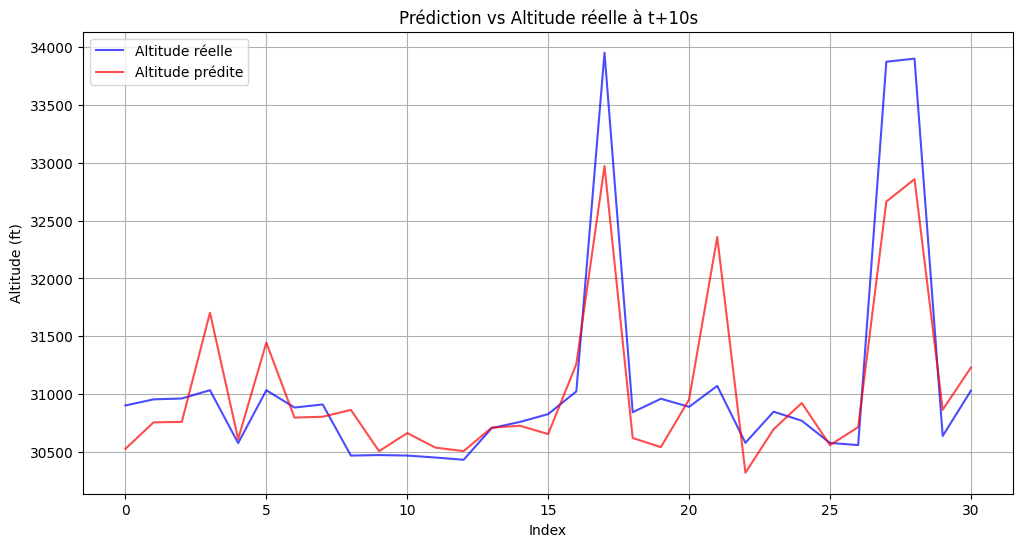

In [60]:
plt.figure(figsize=(12,6))
plt.plot(y_test.values, label="Altitude réelle", color="blue", alpha=0.7)
plt.plot(y_pred, label="Altitude prédite", color="red", alpha=0.7)
plt.xlabel("Index")
plt.ylabel("Altitude (ft)")
plt.title("Prédiction vs Altitude réelle à t+10s")
plt.legend()
plt.grid(True)
plt.show()